# Policy Gradient Crypto-Currency Trading

In [2831]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
from HuobiServices import *
from DataUtils import *
import talib
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
from collections import OrderedDict
%matplotlib inline

In [1121]:
lmap=lambda func,it: list(map(lambda x:func(x),it))
lfilter=lambda func,it: list(filter(lambda x:func(x),it))
z_score=lambda x:(x-np.mean(x,axis=0))/(np.std(x,axis=0)+1e-5)

In [2826]:
class PG_Crypto_portfolio(object):
    def __init__(self, feature_number, action_size=1,gamma=0.95, hidden_units_number=[300, 300, 128], learning_rate=0.001):
        tf.reset_default_graph()
        self.s = tf.placeholder(dtype=tf.float32, shape=[None, feature_number], name='s')
        self.a = tf.placeholder(dtype=tf.int32, shape=[None,action_size], name='a')
        self.r = tf.placeholder(dtype=tf.float32, shape=[None], name='r')
        self.action_size=action_size
        self.gamma = gamma
        self.a_buffer = []
        self.r_buffer = []
        self.s_buffer = []
        self.dropout_keep_prob = tf.placeholder(dtype=tf.float32, shape=[], name='dropout_keep_prob')
        with tf.variable_scope('policy', initializer=tf.contrib.layers.xavier_initializer(uniform=True),regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            self.a_prob = self._add_dense_layer(inputs=self.s, output_shape=hidden_units_number, drop_keep_prob=self.dropout_keep_prob, act=tf.nn.relu, use_bias=True)
            self.a_prob = self._add_dense_layer(inputs=self.a_prob, output_shape=[self.action_size], drop_keep_prob=self.dropout_keep_prob, act=None, use_bias=True)
            self.a_out = tf.nn.softmax(self.a_prob)
        with tf.variable_scope('reward'):
            negative_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.a_prob, labels=self.a)
        with tf.variable_scope('train'):
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.loss = tf.reduce_mean(negative_cross_entropy * self.r)
            self.train_op = optimizer.minimize(self.loss)
        self.init_op = tf.global_variables_initializer()
        self.session = tf.Session()
        self.saver = tf.train.Saver()
    def init_model(self):
        self.session.run(self.init_op)
    
    def _add_dense_layer(self, inputs, output_shape, drop_keep_prob, act=tf.nn.relu, use_bias=True):
        output = inputs
        for n in output_shape:
            output = tf.layers.dense(output, n, activation=act, use_bias=use_bias)
            output = tf.nn.dropout(output, drop_keep_prob)
        return output
    
    def _add_gru_cell(self, units_number, activation=tf.nn.relu):
        return tf.contrib.rnn.GRUCell(num_units=units_number, activation=activation)
    
    def train(self, drop=0.85):
        random_index=np.arange(len(self.a_buffer))
        np.random.shuffle(random_index)
#         I did't use the normalized reward
        reward_normalized = self._get_normalized_rewards()
        feed = {
            self.a: np.array(self.a_buffer)[random_index],
            self.r: np.array(self.r_buffer)[random_index],
            self.s: np.array(self.s_buffer)[random_index],
            self.dropout_keep_prob: drop
        }
        _, loss = self.session.run([self.train_op, self.loss], feed_dict=feed)
        return loss
    
    def _get_normalized_rewards(self):
        reward_normalized = np.zeros_like(self.r_buffer)
        reward_delta = 0
        for index in reversed(range(0, len(self.r_buffer))):
            reward_delta = reward_delta * self.gamma + self.r_buffer[index]
            reward_normalized[index] = reward_delta
        reward_normalized -= np.mean(reward_normalized)
        reward_normalized /= np.std(reward_normalized)
        return reward_normalized
    
    def restore_buffer(self):
        self.a_buffer = []
        self.r_buffer = []
        self.s_buffer = []
    
    def save_transation(self, s, a, r):
        self.a_buffer.append(a)
        self.r_buffer.append(r)
        self.s_buffer.append(s)
    
    def trade(self, s, train=False, drop=1.0):
        feed = {
            self.s: s,
            self.dropout_keep_prob: drop
        }
        a_prob = self.session.run([self.a_out], feed_dict=feed)
        a_prob = a_prob[0].flatten()
        if train:
            a_indices = np.arange(a_prob.shape[0])
            target_index=np.random.choice(a_indices, p=a_prob)
            a=np.zeros(a_prob.shape[0])
            a[target_index]=1.0
            return a
        else:
            target_index=np.argmax(a_prob)
            a=np.zeros(a_prob.shape[0])
            a[target_index]=1.0
            return a
    def load_model(self, model_path='./PGModel'):
        self.saver.restore(self.session, model_path + '/model')
    
    def save_model(self, model_path='./PGModel'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        model_file = model_path + '/model'
        self.saver.save(self.session, model_file)

In [2811]:
# assets=['kanbtc','mdsbtc','socbtc','xrpbtc','dbcbtc','eosbtc','wiccbtc','letbtc']
# assets=['kan','eos','mana','wicc','soc']
# assets=['kan','wicc','edu','eos','let']
# assets=['mana', 'kan', 'btm', 'mds', 'bat']
assets=['ont', 'kan', 'mana', 'ht']
# assets=['ont','ht']

In [2820]:
asset_data=lfilter(lambda x:x[1] is not None,lmap(lambda x:(x,kline(x,interval='15min',count=2000)),assets))
asset_data=lmap(lambda x:(x[0],generate_tech_data(x[1],close_name='close',high_name='high',low_name='low',open_name='open',max_time_window=10)),asset_data)
asset_data=OrderedDict(asset_data)
asset_data=pd.Panel(asset_data)

In [2834]:
model=PG_Crypto_portfolio(action_size=asset_data.shape[0]+1,feature_number=asset_data.shape[2]*asset_data.shape[0],learning_rate=1e-3)
model.init_model()
model.restore_buffer()

In [2835]:
normalize_length=10
train_length=50
batch_size=20
c=0
epoch=50
train_r=[]
test_r=[]
for e in range(epoch):
    test_reward=[]
    test_actions=[]
    train_reward=[]
    for b in range(batch_size):
        previous_action=np.zeros(asset_data.shape[0]+1)
        for t in range(b*train_length+normalize_length,(b+1)*train_length+normalize_length):
            state=asset_data[:,t-normalize_length:t,:].values
            state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
            state=z_score(state)[None,-1]
            action=model.trade(state,train=True,drop=1.0)
            r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
            model.save_transation(a=action,s=state[0],r=r)
            previous_action=action
            train_reward.append(r)
        loss=model.train(drop=1.0)
        model.restore_buffer()
    model.restore_buffer()
    print(e,'train_reward',np.sum(train_reward))
    train_r.append(np.sum(train_reward))
    previous_action=np.zeros(asset_data.shape[0]+1)
    for t in range(train_length*batch_size+normalize_length,asset_data.shape[1]):
        state=asset_data[:,t-normalize_length:t,:].values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        state=z_score(state)[None,-1]
        action=model.trade(state,train=False)
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        previous_action=action
        test_reward.append(r)
        test_actions.append(action)
    print(e,'test_reward',np.sum(test_reward))
    test_r.append(np.sum(test_reward))
    model.restore_buffer()
    if np.sum(np.sum(test_reward))>0.4: break
model.restore_buffer()

0 train_reward 0.07903108208347442
0 test_reward 0.37134288540323734
1 train_reward 0.7204701544096683
1 test_reward 0.10964580416566605
2 train_reward 0.8790297189793819
2 test_reward 0.26180091619312373
3 train_reward 1.0286430711566938
3 test_reward 0.2587114560401458
4 train_reward 0.9537160810809838
4 test_reward 0.18478901388061808
5 train_reward 1.0703179821380218
5 test_reward 0.341236296849047
6 train_reward 1.220744953250687
6 test_reward 0.4549656041713206


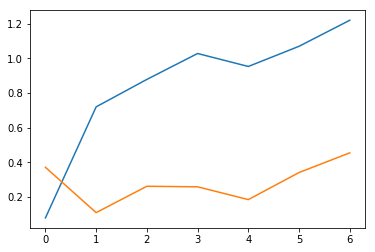

In [2836]:
plt.plot(train_r)
plt.plot(test_r)

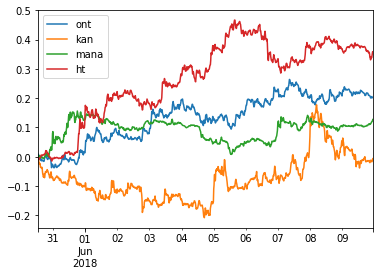

In [2837]:
asset_data[:,normalize_length:train_length*batch_size+normalize_length,'diff'].cumsum().plot()

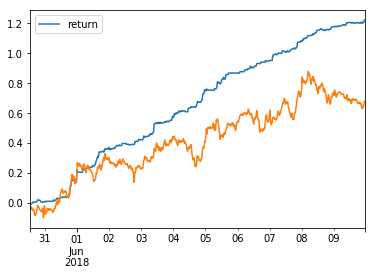

In [2838]:
pd.DataFrame(train_reward,index=asset_data[:,normalize_length:train_length*batch_size+normalize_length,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,normalize_length:train_length*batch_size+normalize_length,'diff'].sum(axis=1).cumsum().plot()

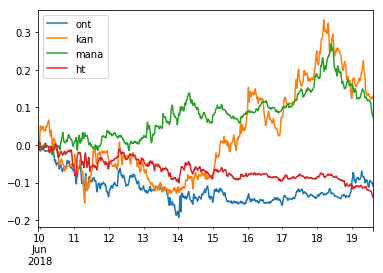

In [2839]:
asset_data[:,train_length*batch_size+normalize_length:,'diff'].cumsum().plot()

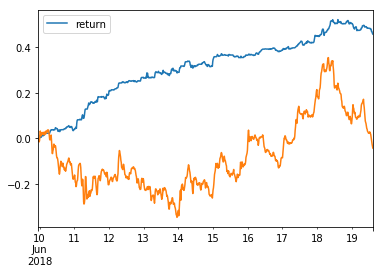

In [2840]:
pd.DataFrame(test_reward,index=asset_data[:,train_length*batch_size+normalize_length:,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,train_length*batch_size+normalize_length:,'diff'].sum(axis=1).cumsum().plot()

In [2841]:
np.sum(test_reward)

0.4549656041713206

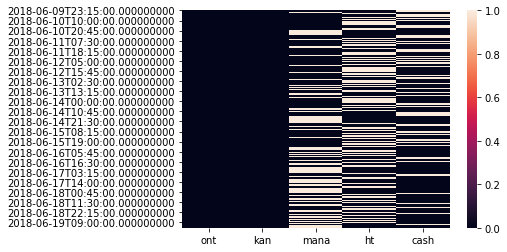

In [2842]:
test_action_df=pd.DataFrame(test_actions,index=asset_data[:,train_length*batch_size+normalize_length:,'diff'].index,columns=list(asset_data.items)+['cash'])
sns.heatmap(test_action_df)